# Mid-air Loss of Separation Detection Module (MLSDM)

Author: Yanyu Wang, Carnegie Mellon University

Email: yanyuwan@andrew.cmu.edu

# Overview of MLSDM Module
This module uses data collected from ASU's Air Traffic Controller Simulation Experiments where three 25 minute approach scenarios were simulated - a baseline workload, a high workload under nominal conditions, and a high workload under off-nominal conditions. Information on these data can be found on the ASU ULI's website [here](https://uli.asu.edu/wp-content/uploads/2020/08/Presentation-AIAA-talk-2019-Task-3-Human-Systems-Integration.pdf). 

The performance measure of the ATC experiments in each scenario were Loss of Separation (LoS) where aircraft fail to maintain minimum separation distances in controlled airspace. The presence of LoS within each sequential 5 second time interval is shown in ``los.csv``. Similarly, the number of aircraft in the the current and past 9 time intervals are shown in ``n_data.csv``. Finally, the number of turning aicraft computed in the current and past 9 time intervals are shown in ``tn_data.csv``. 

Therefore, this module uses number of aircraft and number of turning aircraft at the current time step and some previous time interval to train a model to predict LoS. The aim is support air traffic controllers in alerting when LoS is likely to occur over a given time horizon. More information about the methods in this module can be found [here](https://doi.org/10.1109/WSC48552.2020.9384047).

## Installing the required Python packages
The required Python packages for this module are:
- **[```pandas```]**
- **[```sklearn```]**
- **[```seaborn```]**
    
In the Ubuntu or Anaconda terminal, execute ```conda install pandas sklearn seaborn```. 

## Step 1: Visualizing Training Data
### 1a: Visualize LoS Data

In [8]:
import pandas as pd

y = pd.read_csv('los.csv')
y.head()

,LoSs
0,0
1,0
2,0
3,0
4,0


### 1b: Visualize Number of Aircraft Data

In [9]:
n_data = pd.read_csv('n_data.csv')
n_data.head()

,0,1,2,3,4,5,6,7,8,9
0,2,2,1,1,1,1,1,1,1,1
1,2,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,2


### 1c. Visualize Number of Turning Aircraft Data

In [10]:
tn_data = pd.read_csv('tn_data.csv')
tn_data.head()

,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


## Step 2: Develop Class for Training LoS Models
The developed ```train_los_model``` class contains the three methods building in complexity:
- ```model_based_on_N```
- ```model_based_on_TN```
- ```model_based_on_N_and_TN```

This class uses logistic regression over the supplied data and allows for visualization if desired.

In [12]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import repeat
plt.rcParams['figure.figsize'] = (16,16)

class train_los_model(object):
    def __init__(self):
        self.n = 1455 # Specific time duration request
    def model_based_on_N(self,x,y,visualization=True):
        assert int(list(x.columns)[0]) == 0, "Wrong input file"
        # x = pd.read_csv('l_1_x_2_n.csv')
        # y = pd.read_csv('l_1_y_2.csv')
        df_result = pd.DataFrame(columns=['i','j','Accuracy_Rate','F1_Score'])
        x_values=x.values
        y_values = y.values.ravel()
        n = self.n
        i_list = []
        j_list = []
        acc_list = []
        f1_list = []
        for i in range(0,11):
            for j in range(0,11):
                if i < j:
                    x_train = x_values[:n, i:j]
                    y_train = y_values[:n]

                    x_test = x_values[n:, i:j]
                    y_test = y_values[n:]

                    logisticRegr = LogisticRegression()
                    logisticRegr.fit(x_train, y_train)
                    logisticRegr.predict(x_test[0:])
                    predictions = logisticRegr.predict(x_test)
                    score = logisticRegr.score(x_test, y_test)
                    score = "%.5f" % score
                    cm = metrics.confusion_matrix(y_test, predictions)
                    F1_score_value = f1_score(y_test, predictions, average='binary')
                    F1_score_value = "%.5f" % F1_score_value

                    i_list.append(int(i)+1)
                    j_list.append(int(j))
                    acc_list.append(float(score))
                    f1_list.append(float(F1_score_value))

        df_result.loc[:, 'i'] = i_list
        df_result.loc[:, 'j'] = j_list
        df_result.loc[:, 'Accuracy_Rate'] = acc_list
        df_result.loc[:, 'F1_Score'] = f1_list


        if visualization ==True:
            # visualization
            data = df_result
            result = data.pivot_table(index='i', columns='j', values='F1_Score')
            sns.set(font_scale=2)
            sns.heatmap(result, annot=True, fmt=".5f", cmap='RdBu_r', annot_kws={"size": 15})
            plt.xlabel("End Timestamp", size=15)
            plt.ylabel("Start Timestamp", size=15)
            plt.show()
            data = df_result
            result = data.pivot_table(index='i', columns='j', values='Accuracy_Rate')
            sns.set(font_scale=2)
            sns.heatmap(result, annot=True, fmt=".5f", cmap='RdBu_r', annot_kws={"size": 15})
            plt.xlabel("End Timestamp", size=15)
            plt.ylabel("Start Timestamp", size=15)
            plt.show()
        return df_result
    def model_based_on_TN(self,x,y,visualization=True):
        assert int(list(x.columns)[0]) == 10,"Wrong input file"
        # x = pd.read_csv('l_1_x_2_tn.csv')
        # y = pd.read_csv('l_1_y_2.csv')
        df_result = pd.DataFrame(columns=['i','j','Accuracy_Rate','F1_Score'])
        x_values=x.values
        y_values = y.values.ravel()
        n = self.n
        i_list = []
        j_list = []
        acc_list = []
        f1_list = []
        for i in range(0,11):
            for j in range(0,11):
                if i < j:
                    x_train = x_values[:n, i:j]
                    y_train = y_values[:n]

                    x_test = x_values[n:, i:j]
                    y_test = y_values[n:]

                    logisticRegr = LogisticRegression()
                    logisticRegr.fit(x_train, y_train)
                    logisticRegr.predict(x_test[0:])
                    predictions = logisticRegr.predict(x_test)
                    score = logisticRegr.score(x_test, y_test)
                    score = "%.5f" % score
                    cm = metrics.confusion_matrix(y_test, predictions)
                    F1_score_value = f1_score(y_test, predictions, average='binary')
                    F1_score_value = "%.5f" % F1_score_value

                    i_list.append(int(i)+1)
                    j_list.append(int(j))
                    acc_list.append(float(score))
                    f1_list.append(float(F1_score_value))

        df_result.loc[:, 'i'] = i_list
        df_result.loc[:, 'j'] = j_list
        df_result.loc[:, 'Accuracy_Rate'] = acc_list
        df_result.loc[:, 'F1_Score'] = f1_list


        if visualization ==True:
            # visualization
            data = df_result
            result = data.pivot_table(index='i', columns='j', values='F1_Score')
            sns.set(font_scale=2)
            sns.heatmap(result, annot=True, fmt=".5f", cmap='RdBu_r', annot_kws={"size": 15})
            plt.xlabel("End Timestamp", size=15)
            plt.ylabel("Start Timestamp", size=15)
            plt.show()
            data = df_result
            result = data.pivot_table(index='i', columns='j', values='Accuracy_Rate')
            sns.set(font_scale=2)
            sns.heatmap(result, annot=True, fmt=".5f", cmap='RdBu_r', annot_kws={"size": 15})
            plt.xlabel("End Timestamp", size=15)
            plt.ylabel("Start Timestamp", size=15)
            plt.show()
        return df_result
    def model_based_on_N_and_TN(self,n_data,tn_data,y,visualization=True):
        # n_data = pd.read_csv('l_1_x_2_n.csv').values
        # tn_data = pd.read_csv('l_1_x_2_tn.csv').values
        # y = pd.read_csv('l_1_y_2.csv').values
        assert int(list(n_data.columns)[0]) == 0, "Wrong input file"
        assert int(list(tn_data.columns)[0]) == 10, "Wrong input file"
        n_data = n_data.values
        tn_data = tn_data.values
        y = y.values.ravel()
        n = self.n

        df_result = pd.DataFrame(columns=['i', 'j', 'k','p','Accuracy_Rate', 'F1_Score'])

        i_list = []
        j_list = []
        k_list = []
        p_list = []
        acc_list = []
        f1_list = []
        for i in range(0, 11):
            for j in range(0, 11):
                if i < j:
                    x_train_n = n_data[:n, i:j]
                    x_test_n = n_data[n:, i:j]
                    for k in range(0, 11):
                        for p in range(0, 11):
                            if k < p:
                                x_train_tn = tn_data[:n, k:p]
                                x_test_tn = tn_data[n:, k:p]

                                x_train = np.hstack((x_train_n, x_train_tn))

                                y_train = y[:n]

                                x_test = np.hstack((x_test_n, x_test_tn))
                                y_test = y[n:]

                                logisticRegr = LogisticRegression(max_iter=1000)
                                logisticRegr.fit(x_train, y_train)
                                logisticRegr.predict(x_test[0:])
                                predictions = logisticRegr.predict(x_test)
                                score = logisticRegr.score(x_test, y_test)
                                score = "%.5f" % score
                                cm = metrics.confusion_matrix(y_test, predictions)
                                F1_score_value = f1_score(y_test, predictions, average='binary')
                                F1_score_value = "%.5f" % F1_score_value

                                i_list.append("{:02d}".format(int(i) + 1))
                                j_list.append("{:02d}".format(int(j)))
                                k_list.append("{:02d}".format(int(k) + 1))
                                p_list.append("{:02d}".format(int(p)))
                                acc_list.append(float(score))
                                f1_list.append(float(F1_score_value))
        df_result.loc[:, 'i'] = list(zip(i_list,repeat('-'),j_list))
        df_result.loc[:, 'j'] = list(zip(k_list,repeat('-'),p_list))
        df_result.loc[:, 'Accuracy_Rate'] = acc_list
        df_result.loc[:, 'F1_Score'] = f1_list
        if visualization == True:
            # visualization
            data = df_result
            result = data.pivot_table(index='i', columns='j', values='F1_Score')
            labels = []
            for i in range(1, 11):
                for j in range(1, 11):
                    if i <= j:
                        label = str(i) + "~" + str(j)
                        labels.append(label)

            sns.heatmap(result, annot=False, cmap='RdBu_r', yticklabels=True, xticklabels=True)
            plt.xlabel("The Time Window of the Number of Turning Aircraft", size=15)
            plt.ylabel("The Time Window of Traffic Density", size=15)
            plt.show()

            data = df_result
            result = data.pivot_table(index='i', columns='j', values='Accuracy_Rate')
            labels = []
            for i in range(1, 11):
                for j in range(1, 11):
                    if i <= j:
                        label = str(i) + "~" + str(j)
                        labels.append(label)

            sns.heatmap(result, annot=False, cmap='RdBu_r', yticklabels=True, xticklabels=True)

            plt.xlabel("The Time Window of the Number of Turning Aircraft", size=15)
            plt.ylabel("The Time Window of Traffic Density", size=15)

            plt.show()


## Step 3: Train Models and Predict LoS
### Initialize ```train_los_model``` class

In [13]:
train_model = train_los_model()

### 3a. Train LoS model using traffic density

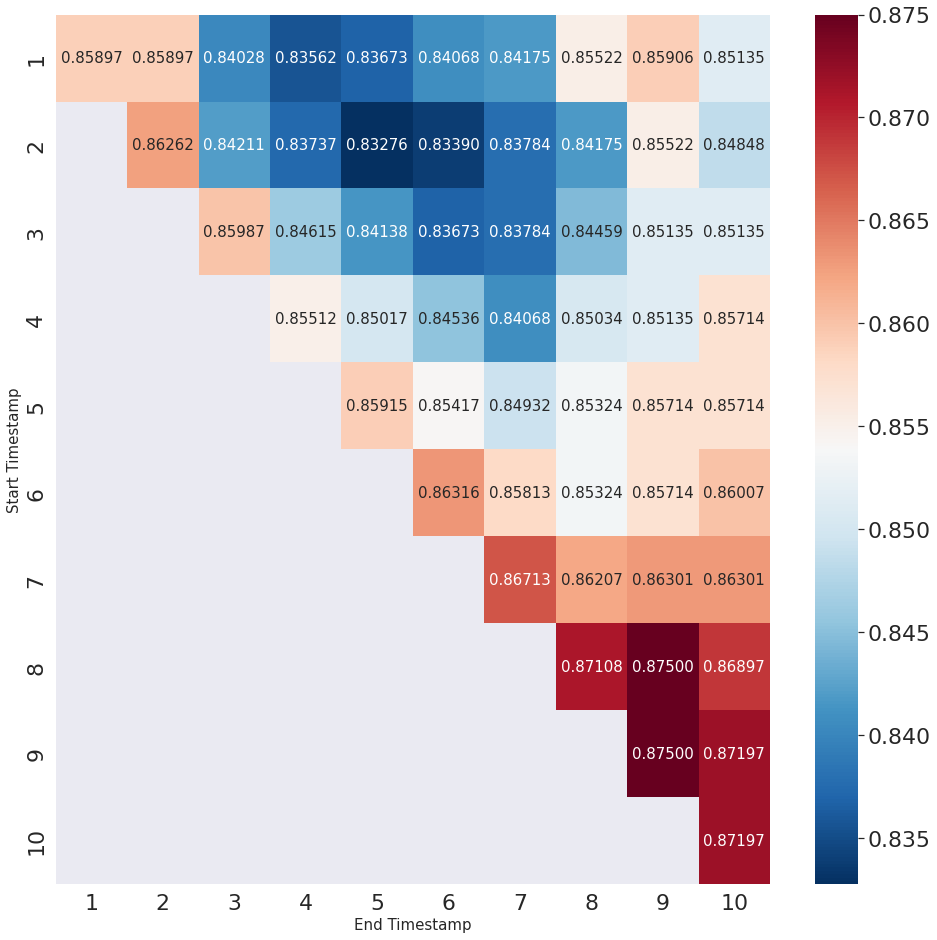

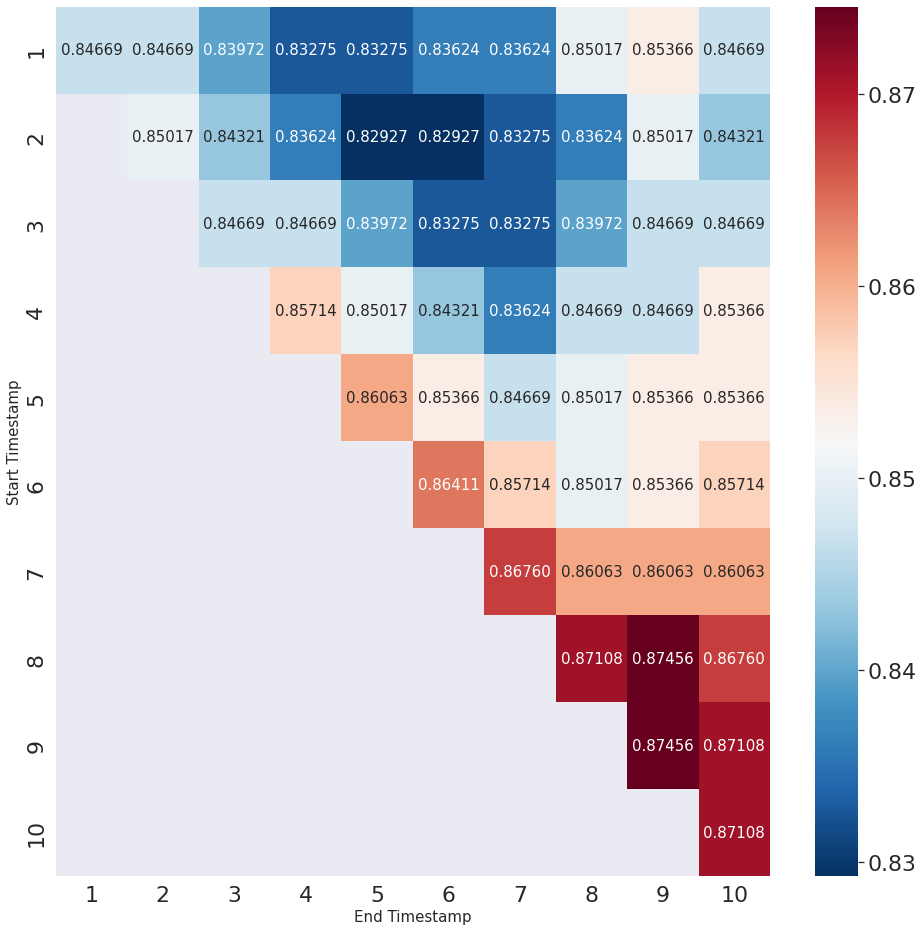

In [14]:
model_based_on_N = train_model.model_based_on_N(n_data, y, visualization=True)

### 3b. Train LoS model using only turning behavior

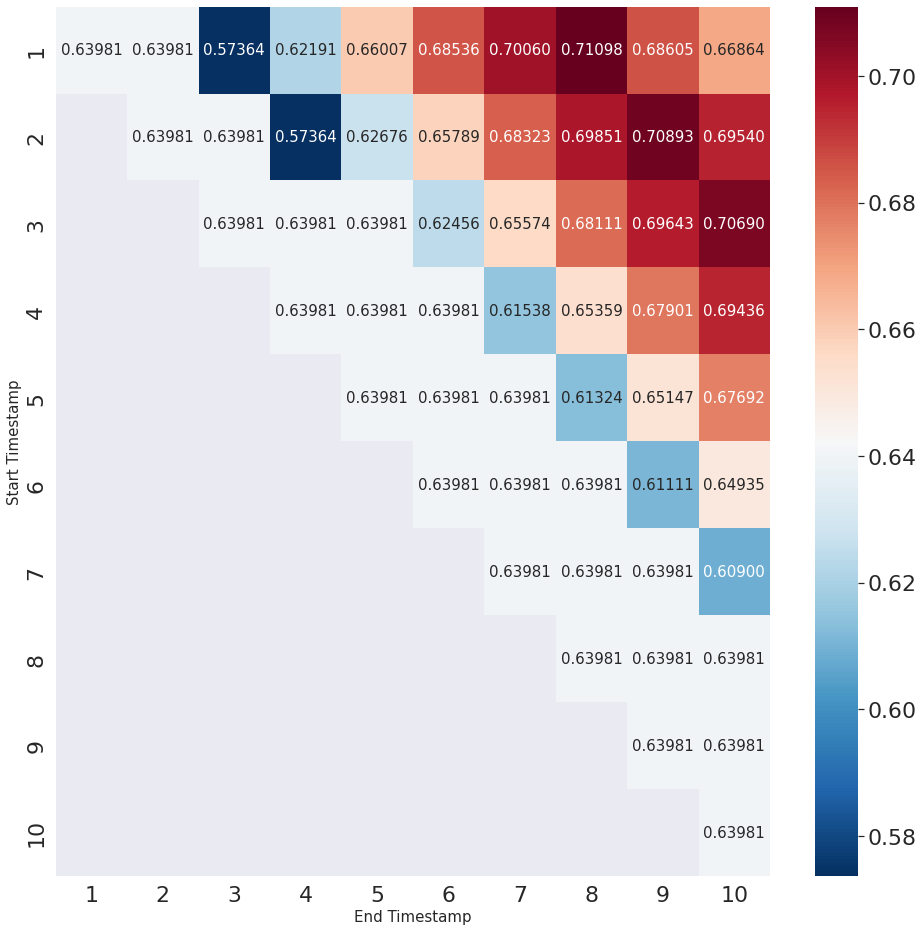

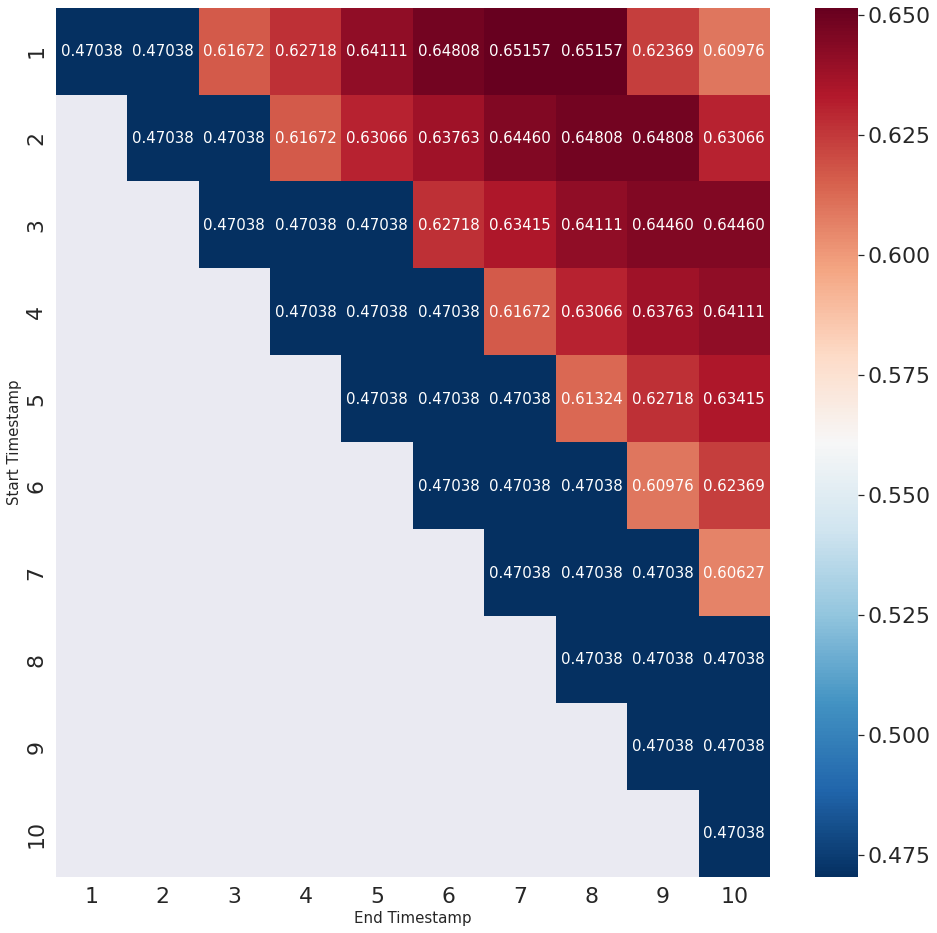

In [16]:
model_based_on_TN = train_model.model_based_on_TN(tn_data, y, visualization=True)

### Train LoS model using both traf

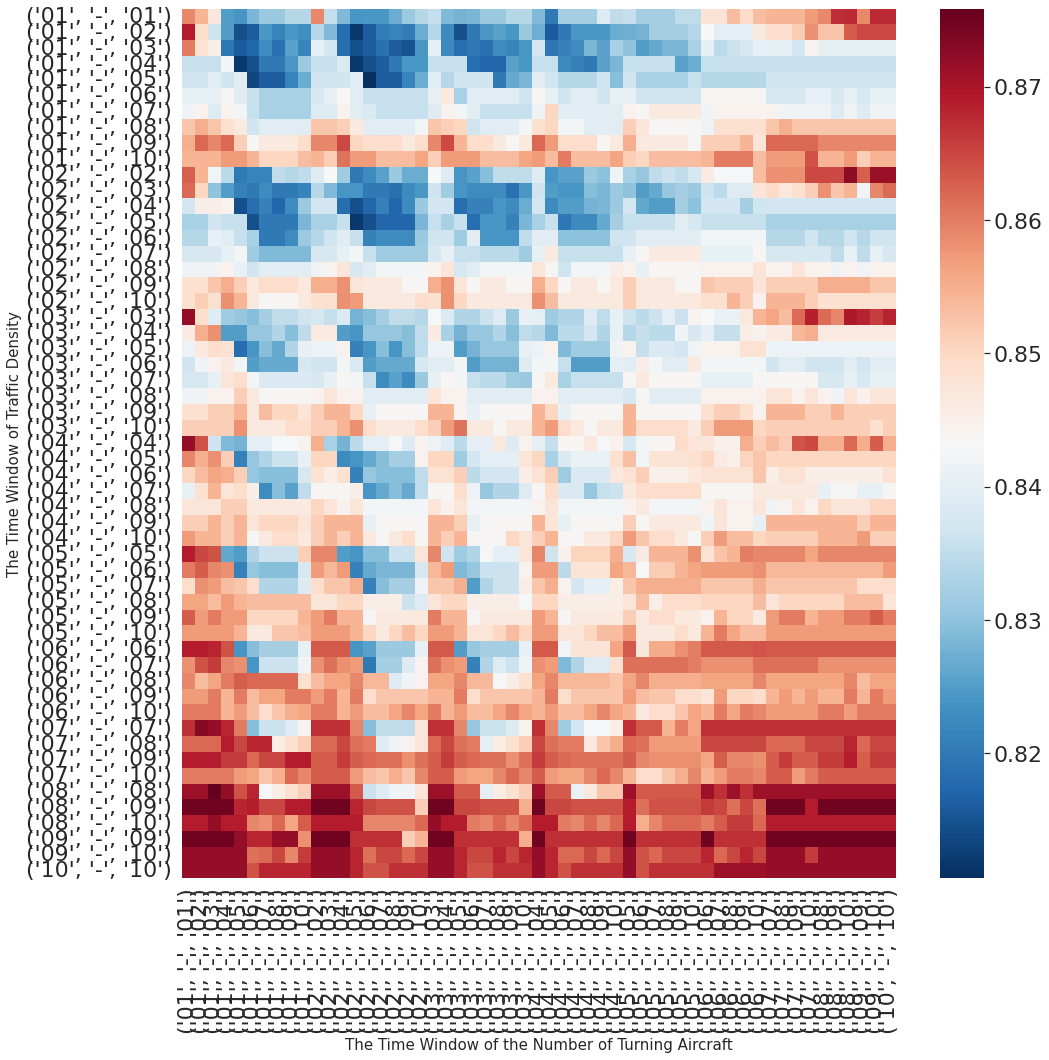

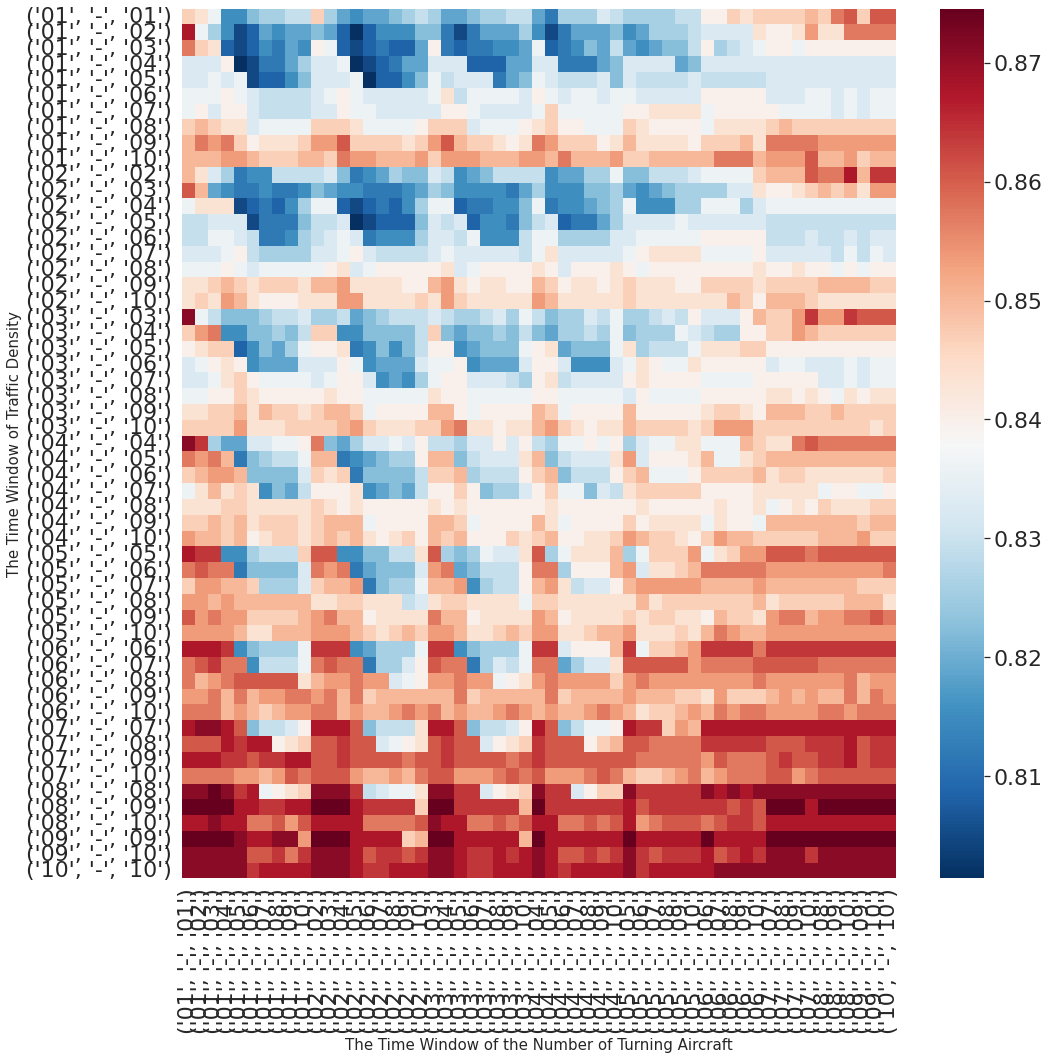

In [20]:
model_based_on_N_and_TN = train_model.model_based_on_N_and_TN(n_data,tn_data,y,visualization=True)